In [1]:
import numpy as np 
import pandas as pd
from pandas import Series
import sys
import time
import datetime
import requests as r
import json
from bs4 import BeautifulSoup
import os

import pandas_profiling
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter('ignore')

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.ensemble import StackingRegressor

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor  
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.base import clone

In [2]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt
# Фиксируем RANDOM_SEED, чтобы эксперименты были воспроизводимы!
RANDOM_SEED = 42

Python       : 3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]
Numpy        : 1.19.2


In [3]:
def mape(y_true, y_pred):
    '''Функция для вычисления итоговой метрики MAPE(Mean Percentage Absolute Error) '''
    return np.mean(np.abs((y_pred-y_true)/y_true))

def learn_print_MAPE(type_model):
    '''Функцию для обучения модели и печати MAPE'''
    type_model.fit(X_train, y_train)
    predict = type_model.predict(X_test)
    print(f"Точность модели по метрике MAPE: {(mape(y_test, predict))*100:0.2f}%")
    
# функция вывода  всех выбросов
def count_outlier(df_in, col_name):
    '''функция вывода  всех выбросов в список'''
    q25, q75 = np.percentile(df_in[col_name], [25, 75])
    iqr = q75 - q25
    fence_low = q25 - 1.5*iqr
    fence_high = q75 + 1.5*iqr
    return np.where((df_in[col_name] > fence_high) | (df_in[col_name] < fence_low))[0]


def box_and_hist(column, bins, df):
    '''горизонтальный Boxplot + гистограма'''
    fig, (ax_box, ax_hist) = plt.subplots(2, figsize=(15, 5),
                                          sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
    sns.boxplot(df[column], ax=ax_box)
    sns.distplot(df[column], ax=ax_hist, bins=bins)
    ax_box.set_title(f'Распределение значений в {column}\n\
                     Выбросов(iqr*1.5) - {len(count_outlier(df, column))}', fontsize=15)

# Setup

In [4]:
VERSION    = 16
DIR_TRAIN  = 'C:/Users/79781/project_number_5/Data/all_auto_ru_09_09_2020/' # подключил к ноутбуку внешний датасет
DIR_TEST   = 'C:/Users/79781/project_number_5/Data/test/'
VAL_SIZE   = 0.20   # 20%

In [5]:
!ls '../input'
train = pd.read_csv(DIR_TRAIN+'all_auto_ru_09_09_2020.csv') # датасет для обучения модели
test = pd.read_csv(DIR_TEST+'test.csv')
sample_submission = pd.read_csv(DIR_TEST+'sample_submission.csv')

"ls" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


# Data

In [6]:
pd.set_option('display.max_columns', 36) # показывать больше колонок
train.sample(5)

,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,engineDisplacement,enginePower,description,mileage,Комплектация,Привод,Руль,Состояние,Владельцы,ПТС,Таможня,Владение,price,start_date,hidden,model
42445,Хэтчбек 3 дв.,MITSUBISHI,FAFBFB,бензин,1988.0,1.5 MT (84 л.с.),3.0,1990,HATCHBACK_3_DOORS MECHANICAL 1.5,MECHANICAL,1.5,84.0,Машина абсолютно без технических проблем. По м...,451000,{'id': '0'},передний,LEFT,NaN,3.0,ORIGINAL,True,"{'year': 2011, 'month': 8}",65000.0,2020-04-07T18:08:19Z,NaN,COLT
80203,Внедорожник 5 дв.,LAND_ROVER,FAFBFB,дизель,2011.0,6-speed 2.2d AT (150 л.с.) 4WD,5.0,2014,ALLROAD_5_DOORS AUTOMATIC 6-speed,AUTOMATIC,6-speed,150.0,Воспользуйтесь системами TRADE-IN и кредитован...,120300,{'id': '0'},полный,LEFT,NaN,3.0,DUPLICATE,True,NaN,1500000.0,2020-08-11T10:06:11Z,NaN,EVOQUE
26098,Седан,HYUNDAI,CACECB,бензин,2003.0,1.6 AT (107 л.с.),4.0,2003,SEDAN AUTOMATIC 1.6,AUTOMATIC,1.6,107.0,Автомобиль в хорошем состоянии ходовая мотор ...,198445,{'id': '0'},передний,LEFT,NaN,2.0,ORIGINAL,True,NaN,160000.0,2020-08-21T07:47:57Z,NaN,ELANTRA
53428,Седан,OPEL,CACECB,бензин,2006.0,1.6 MT (115 л.с.),4.0,2008,SEDAN MECHANICAL 1.6,MECHANICAL,1.6,115.0,В хорошем состоянии вложений не требует 2 комп...,155000,{'id': '0'},передний,LEFT,NaN,2.0,ORIGINAL,True,NaN,310000.0,2020-01-27T18:11:13Z,NaN,ASTRA
70904,Седан,VOLKSWAGEN,040001,бензин,2014.0,1.4 AMT (122 л.с.),4.0,2015,SEDAN ROBOT 1.4,ROBOT,1.4,122.0,Начало эксплуатации март 2015. Оригинал ПТС. 2...,238995,{'id': '0'},передний,LEFT,NaN,2.0,ORIGINAL,True,NaN,545000.0,2020-02-11T15:47:58Z,NaN,JETTA


In [7]:
pd.set_option('display.max_columns', 36) # показывать больше колонок
test.sample(5)

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,image,mileage,modelDate,model_info,model_name,name,numberOfDoors,parsing_unixtime,priceCurrency,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня
16343,внедорожник 5 дв.,MERCEDES,https://auto.ru/cars/used/sale/mercedes/m_klas...,чёрный,NaN,"Америкос, пригнан в 1998 году, реально я второ...",3.2 LTR,218 N12,"{""cruise-control"":true,""tinted-glass"":true,""es...",бензин,https://autoru.naydex.net/ESooa9149/468b9eoMem...,230000,1997,"{""code"":""M_KLASSE"",""name"":""M-Класс"",""ru_name"":...",M_KLASSE,320 3.2 AT (218 л.с.) 4WD,5,1603243590,RUB,1998,1099880658,"{""id"":""20495624"",""name"":""320"",""nameplate"":""320...",ALLROAD_5_DOORS AUTOMATIC 3.2,автоматическая,EUROPEAN,3 или более,15 лет и 7 месяцев,Дубликат,полный,Левый,Не требует ремонта,Растаможен
23466,компактвэн,VOLKSWAGEN,https://auto.ru/cars/used/sale/volkswagen/tour...,чёрный,NaN,При покупке автомобиля до 31 октября \n► Выгод...,1.4 LTR,140 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,92141,2010,"{""code"":""TOURAN"",""name"":""Touran"",""ru_name"":""Ту...",TOURAN,1.4 AMT (140 л.с.),5,1603213866,RUB,2013,1100388092,"{""id"":""20495000"",""displacement"":1390,""engine_t...",COMPACTVAN ROBOT 1.4,роботизированная,EUROPEAN,2 владельца,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
33150,внедорожник 5 дв.,INFINITI,https://auto.ru/cars/used/sale/infiniti/qx70/1...,чёрный,"{""id"":""21106264"",""name"":""Icon"",""available_opti...",Автомобиль продает Лизинговая компания. НЕ САЛ...,3.7 LTR,333 N12,"{""tinted-glass"":true,""esp"":true,""adaptive-ligh...",бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,102456,2013,"{""code"":""QX70"",""name"":""QX70"",""ru_name"":""ку икс...",QX70,3.7 AT (333 л.с.) 4WD,5,1603611405,RUB,2016,1100186118,"{""id"":""20182269"",""displacement"":3696,""engine_t...",ALLROAD_5_DOORS AUTOMATIC 3.7,автоматическая,JAPANESE,1 владелец,3 года и 6 месяцев,Оригинал,полный,Левый,Не требует ремонта,Растаможен
29237,седан,BMW,https://auto.ru/cars/used/sale/bmw/5er/1101345...,синий,"{""id"":""21037026"",""name"":""520d xDrive"",""availab...",Автомобиль продаётся официальным дилером BMW -...,2.0 LTR,190 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",дизель,https://avatars.mds.yandex.net/get-autoru-vos/...,31115,2016,"{""code"":""5ER"",""name"":""5 серии"",""ru_name"":""5 се...",5ER,520d xDrive 2.0d AT (190 л.с.) 4WD,4,1603559240,RUB,2018,1101345076,"{""id"":""20856402"",""name"":""520"",""nameplate"":""520...",SEDAN AUTOMATIC 2.0,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,полный,Левый,Не требует ремонта,Растаможен
12720,хэтчбек 5 дв.,NISSAN,https://auto.ru/cars/used/sale/nissan/note/110...,серый,NaN,Преимущества этого автомобиля:\n\n*ПРОИЗВЕДЕНА...,1.6 LTR,110 N12,"{""airbag-driver"":true,""isofix"":true,""mirrors-h...",бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,127207,2005,"{""code"":""NOTE"",""name"":""Note"",""ru_name"":""Ноут"",...",NOTE,1.6 AT (110 л.с.),5,1603275790,RUB,2008,1101111373,"{""id"":""2308098"",""displacement"":1598,""engine_ty...",HATCHBACK_5_DOORS AUTOMATIC 1.6,автоматическая,JAPANESE,3 или более,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен


In [8]:
print('Нет признаков в train - ', set(test.columns) - set(train.columns))
print('Нет признаков в test - ', set(train.columns) - set(test.columns))

Нет признаков в train -  {'model_name', 'vendor', 'image', 'equipment_dict', 'super_gen', 'model_info', 'sell_id', 'priceCurrency', 'complectation_dict', 'parsing_unixtime', 'car_url'}
Нет признаков в test -  {'price', 'model', 'hidden', 'start_date', 'Комплектация'}


In [9]:
# Переименуем названия колонок в train в соответствии с test
dict_columns_rename = {
    'Комплектация': 'complectation_dict',
    'model': 'model_name',
}
train.rename(columns=dict_columns_rename, inplace=True)

# Удалим лишние столбцы и дубликаты в train
train.drop(['start_date', 'hidden', 'Состояние',
            'name', 'Таможня'], inplace=True, axis=1)
train = train.drop_duplicates()

# Удалим строки где цена отсутсвует
train = train.dropna(subset=['price'])

In [10]:
# Удалим поля в test не влияющих на оценку целевой переменной
test.drop(['priceCurrency', 'image', 'vendor', 'parsing_unixtime', 'sell_id',
           'equipment_dict', 'model_info', 'super_gen', 'car_url', 'Состояние', 'name', 'Таможня'], inplace=True, axis=1)
# Добавим переменную price в test
test['price'] = np.nan
# В test нашел 14 дубликатов, удалять их не стал, количество строк в тесте должно быть неизменным.
print(f'Дубликаты в test: {test.duplicated().sum()}')
# test = test.drop_duplicates()

Дубликаты в test: 14


In [11]:
train['sample'] = 1  # помечаем, где у нас трейн
test['sample'] = 0  # помечаем, где у нас тест
# Объединяем трейн и тест в один датасет,
df = pd.concat([test, train]).reset_index(drop=True)
print(f'train - {train.shape},\ntest - {test.shape},\ndf - {df.shape}')

train - (85391, 22),
test - (34686, 22),
df - (120077, 22)


In [12]:
# Приведём названия всех столбцов к общему типу:
df.rename(columns={'bodyType': 'body_type',
                   'engineDisplacement': 'engine_volume',
                   'enginePower': 'engine_power',
                   'fuelType': 'fuel_type',
                   'modelDate': 'model_date',
                   'numberOfDoors': 'number_of_doors',
                   'productionDate': 'production_date',
                   'vehicleConfiguration': 'vehicle_configuration',
                   'vehicleTransmission': 'vehicle_transmission',
                   'Владельцы': 'owners_qty',
                   'Владение': 'ownership_time',
                   'ПТС': 'licence',
                   'Привод': 'type_of_drive',
                   'Руль': 'steering_wheel',
                   }, inplace=True)

# Отсортируем столбцы для удобства просмотра таблицы с  важным признаками вначале (по моему мнению):
sequence = ['price', 'brand', 'model_name', 'production_date', 'mileage', 'vehicle_transmission',
            'fuel_type', 'owners_qty', 'description', 'complectation_dict',
            'body_type',  'color',  'model_date', 'engine_power', 'number_of_doors', 'vehicle_configuration',
            'engine_volume', 'type_of_drive', 'steering_wheel', 'licence', 'ownership_time', 'sample']

df = df.reindex(columns=sequence)

Признаки датасета
* price - цена автомобиля, целевой параметр,
* brand - марка автомобиля,
* model_name - модель машины,
* production_date - дата производства автомобиля,
* mileage - пробег,
* vehicle_transmission - конфигурация трансмиссии транспортного средства
* fuel_typee - тип топлива,
* owners_qty - количество владельцев,
* description - описание в объявлении,
* complectation_dict - комплектация машины
* body_type - тип кузова,
* color - цвет автомобиля,
* model_date - дата релиза модели,
* engine_power - мощность двигателя, трансмиссия,
* number_of_doors - количество дверей,
* vehicle_configuration - конфигурация транспортного средства (ТС),
* type_of_drive - тип привода,
* steering_wheel - сторона руля,
* licence - паспорт ТС,
* customs - этап растаможки,
* ownership_time - период владения ТС,
* sample - индикатор принадлежности данных к тесту (0) и трейну (1).

# EDA

In [13]:
# С помощь ию ProfileReport создадим статистический отчет по всем признакам. 
# Отчет позволит выявить ошибки, пропуски, дубликаты, высокую корреляцию признаков.
# pandas_profiling.ProfileReport(df)

* имеем 23 признака, 15 из которых категориальные
* присутствуют большое количество пропусков в полях ownership_time(66%) и complectation_dict(23%), owners_qty(8%)
* большинство признаков содержит пропуски менее 0,1% отдельные до 4%, отсутствующие данные в которых можно заполнить медианными значениями:
* дубликаты отсутствуют
* production_date имеет высокую корреляцию с model_date
* Поле milege говорит нам что около 10% машин практически не ездили
* значения в полях: body_type, vehicle_transmission, color, licence, steering_wheel, engine_volume следует привести к единому формату из-за разности значений в test и train.
* неподдерживаемые признаки owners_qty, engine_volum также требуют приведения к единому числовому формату.

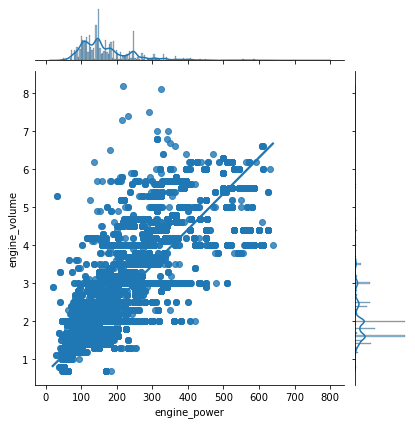

In [14]:
# Составил словарь под замену неугодных значений
rename_item = {'Оригинал': 'ORIGINAL',
               'Дубликат': 'DUPLICATE',
               'автоматическая': 'AUTOMATIC',
               'механическая': 'MECHANICAL',
               'вариатор': 'VARIATOR',
               'роботизированная': 'ROBOT',
               'Левый': 'LEFT',
               'Правый': 'RIGHT',
               '040001': 'чёрный',
               'FAFBFB': 'белый',
               'CACECB': 'серебристый',
               '97948F': 'серый',
               '0000CC': 'синий',
               '200204': 'коричневый',
               'EE1D19': 'красный',
               '007F00': 'зеленый',
               'C49648': 'бежевый',
               '22A0F8': 'голубой',
               '660099': 'пурпурный',
               'DEA522': 'золотой',
               '4A2197': 'фиолетовый',
               'FFD600': 'желтый',
               'FF8649': 'оранжевый',
               'FFC0CB': 'розовый',
               }
# Проведем замену слов, так чтобы  набор значений в train не отличался от test
for column in ['body_type', 'vehicle_transmission', 'color', 'licence', 'steering_wheel']:
    df = df.replace({column: rename_item})  # заменим
    df[column] = df[column].apply(lambda x: None if pd.isnull(
        x) else x.lower())  # приведем все к нижнему регистру

# Оставим только первое число в полях 'owners_qty','engine_power' и переведем их в числовой формат
for column in ['owners_qty', 'engine_power', ]:
    df[column] = df[column].astype(str).apply(lambda x: x.split()[0])
    df[column] = df[column].astype(float)

# Приведём признак engine_volume к строковому типу и  оставим только числовые данные.
df['engine_volume'] = df['engine_volume'].astype(str)
df['engine_volume'] = df['engine_volume'].str.extract(
    '(\d.\d)', expand=False).str.strip()
# Заменим все некорректные числа(объём двигателя в литрах) более 10 на None
df['engine_volume'] = df['engine_volume'].apply(
    lambda x: None if float(x) > 10 else x).astype(float)
# Признаки повторяют друг друга, поэтому преобразуем в дальнейшем мощность двигателя в систему транспортного налогообложения в РФ.
sns.jointplot(x='engine_power', y='engine_volume',
              data=df, kind='reg')

# Заполним пустые значения

price                    34686
brand                        0
model_name                   0
production_date              0
mileage                      0
vehicle_transmission         0
fuel_type                    0
owners_qty               10535
description               3212
complectation_dict       28268
body_type                    0
color                        0
model_date                   0
engine_power                 0
number_of_doors              0
vehicle_configuration        0
engine_volume            20104
type_of_drive                0
steering_wheel               0
licence                    349
ownership_time           79243
sample                       0
dtype: int64


<AxesSubplot:>

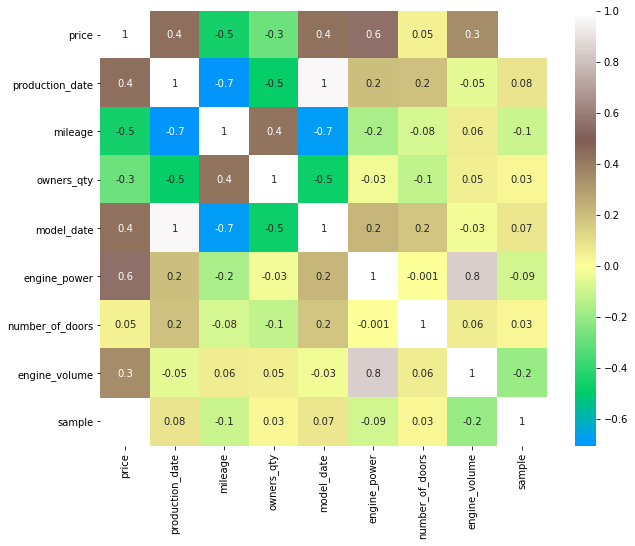

In [15]:
# Удалим одну строку c множеством пропусков
df = df[~df.body_type.isna()]

# посмотрим, где у нас пропуски
print(df.isna().sum())
fig, ax = plt.subplots(figsize=(10, 8))  # посмотрим корреляционные связи
sns.heatmap(df.corr(), cmap='terrain', annot=True, fmt='.1g', center=0, ax=ax)

# Числовые признаки

In [16]:
# заполним пустые значениями объема двигателя(engine_volume) медианой с учетом мощности двигателя в л.с.(engine_power). Хорошая корреляция
df['engine_volume'].fillna(df.groupby(['engine_power'])[
                           'engine_volume'].transform('median'), inplace=True)
# оставшимся 77 спортивным машинам поставим 5 литров.
df['engine_volume'].fillna(5.0, inplace=True)

In [17]:
# Учитывая хорошую корреляционную связь пробега и количество владельцев,
# посчитал среднее значение владельцев в зависимости от пробега.
# Отсюда можно выделить 3 переломных цифры,когда в среднем владелец меняется.
bins = np.arange(0, 170000, 10000)
df.groupby(pd.cut(df.mileage, bins)).owners_qty.median()

mileage
(0, 10000]          1.0
(10000, 20000]      1.0
(20000, 30000]      1.0
(30000, 40000]      1.0
(40000, 50000]      1.0
(50000, 60000]      1.0
(60000, 70000]      2.0
(70000, 80000]      2.0
(80000, 90000]      2.0
(90000, 100000]     2.0
(100000, 110000]    2.0
(110000, 120000]    2.0
(120000, 130000]    2.0
(130000, 140000]    2.0
(140000, 150000]    3.0
(150000, 160000]    3.0
Name: owners_qty, dtype: float64

In [18]:
change_owners = [0, 65000, 145000, 1e6]  # список км смены владельца
labels = [1, 2, 3]
df['mileage_owners'] = pd.cut(df['mileage'], bins=change_owners,
                              labels=labels, include_lowest=True)  # добавим вспомогательное поле
df['owners_qty'] = df['owners_qty'].fillna(
    df['mileage_owners'])  # заполним пропуски
df = df.drop('mileage_owners', axis=1)  # удалим вспомогательное поле

# Категориальные признаки

In [19]:
# Заменим модой пропуски в ПТС на "дубликат".
df['licence'] = df['licence'].fillna('duplicate')
# Дубликат ПТС выдается автовладельцу  когда нет свободного места для внесения новой информации (закончились графы) или он утерян.
# В оригинальном ПТС документе есть 6 полей соответственно 3- 5 владельцев было прежде.

# Заменим пропуски в описании(description) на "без комментариев".
df['description'] = df['description'].fillna('без комментариев')

<AxesSubplot:>

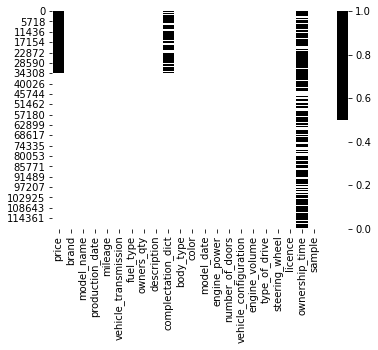

In [20]:
colors = ['w', 'k']
sns.heatmap(df.isna(), cmap=sns.color_palette(colors))

In [21]:
# compectation_dict - очень полезный признак влияющий на цену но к сожалению из-за большого числа пропусков
# в особенности на тесте прийдется удалить

In [22]:
df.drop(['complectation_dict', 'ownership_time'], axis=1, inplace=True)

# Анализ наиболее важных признаков

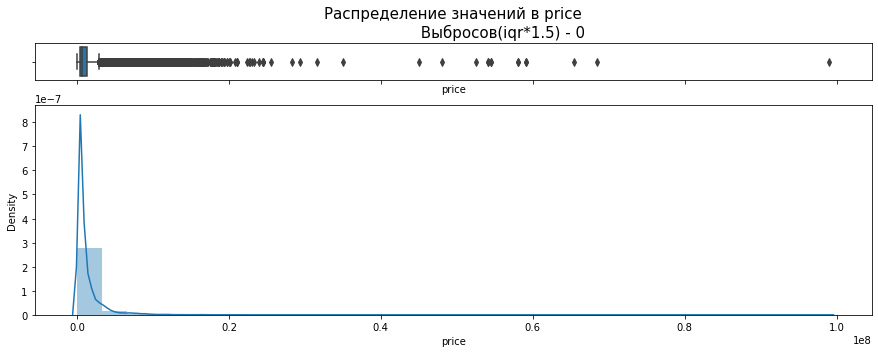

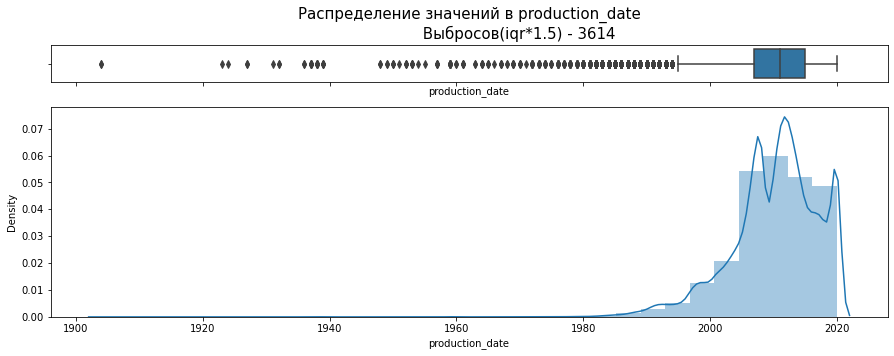

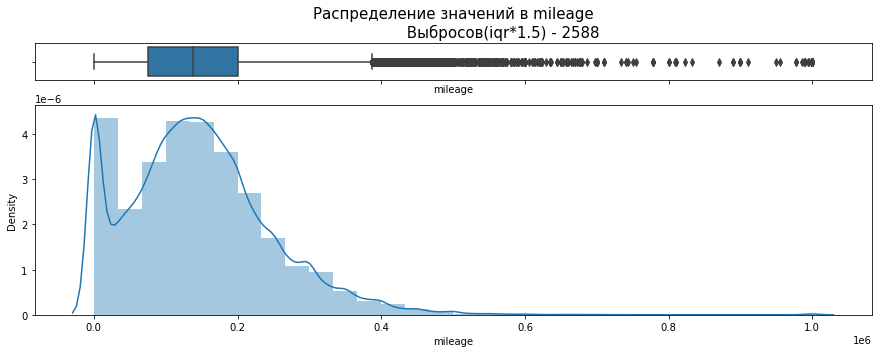

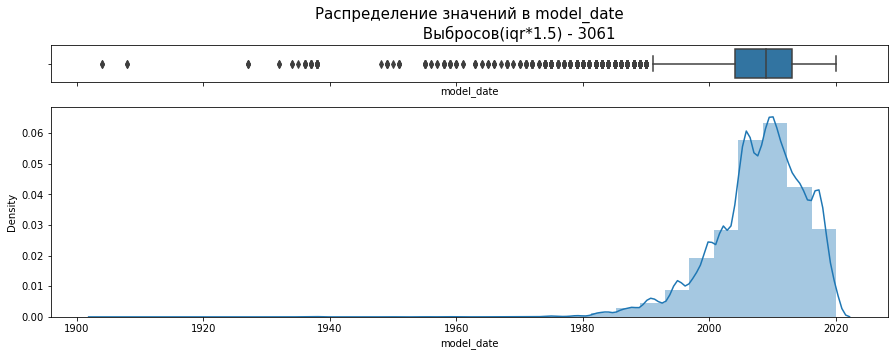

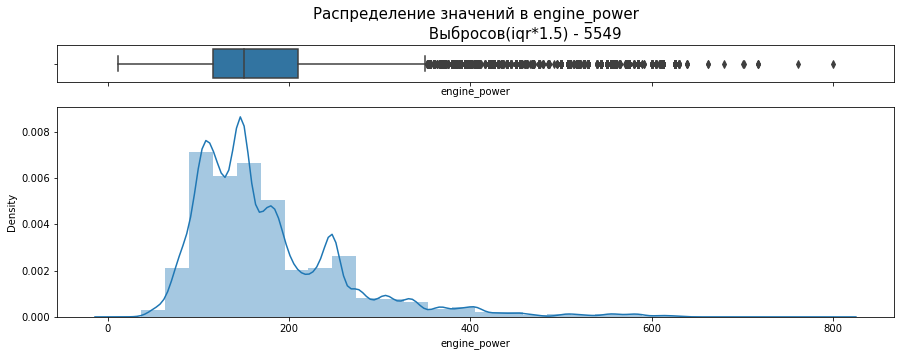

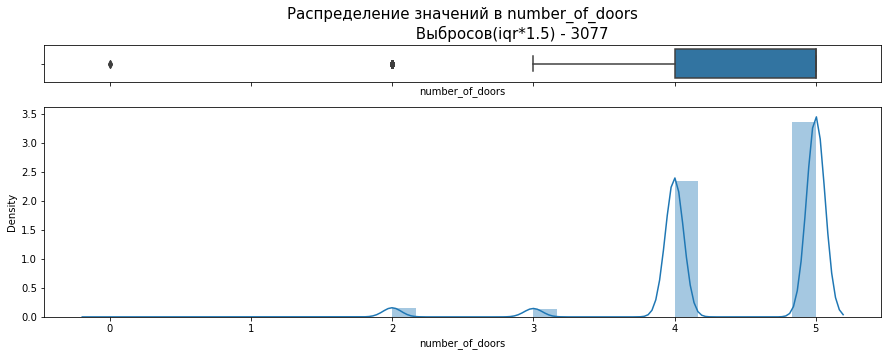

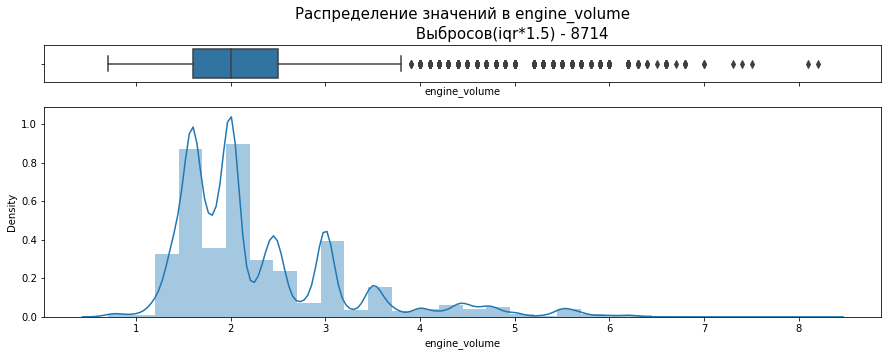

In [23]:
num_cols = ['price',
            'production_date',
            'mileage',
            'model_date',
            'engine_power',
            'number_of_doors',
            'engine_volume']

for i in num_cols:
    box_and_hist(i, bins=30, df=df)

# Feature Engineering

#### Создадим несколько бинарных признаков исходя из модели, которые на практике сильно влияют на стоимость автомобиля:

* laxury - доргие автомобили
* collector - коллекционные автомобили
* sport - спортивные автомобили

In [24]:
# список дорогих марок, любая из которых продается сейчас выше 3 млн.
laxury = list(df.query('price>3e6').model_name.value_counts().keys())
# список коллекционных марок (из машин произведеных до 1960 года )
collector = list(df.query('production_date<1960').model_name.value_counts().keys())
# список спортивных марок(из моделей которые в среднем имеют мощность более 500 л.с.)
sport = list(df.groupby('model_name').engine_power.mean(
).sort_values(ascending=False)[:40].keys())
# закодируем
for value, models in {'laxury': laxury, 'collector': collector, 'sport': sport}.items():
    mask = df['model_name'].isin(models)
    df[value] = mask*1

#### Из числовых, сделаем:

* model_recency - новизна модели на момент производства
* mileage_year - cтепень эксплуатации(пробег/год)

In [25]:
df['model_recency'] = df['production_date'] - df['model_date']
df['model_recency'] = df['model_recency'].apply(lambda x: 0 if x < 0 else x)
df['mileage_year'] = (df['mileage']/(2020.01 - df['production_date']))

#### Создадим из описания(description) несколько числовых признаков:

* количество символов из описания(description_length)
* повторяемость объявлений(repeat_description)

#### Из описания насколько это возможно выделим:

* auto_dealer - кто продает машину, автосалон или частное лицо(перекуп).
* auto_repair - машина продается под восстановление, на запчасти

In [26]:
df['description_length'] = df['description'].map(lambda x: len(x))

dict_count_description = df['description'].value_counts().loc[lambda x: x > 2].to_dict()
df['repeat_description'] = df['description'].map(dict_count_description)
df['repeat_description'].fillna(1, inplace=True)

#### Из описания насколько это возможно выделим:

* auto_dealer - кто продает машину, автосалон или частное лицо(перекуп).
* auto_repair - машина продается под восстановление, на запчасти

In [27]:
auto_dealer = 'тест-драйв|менеджер|клиент|Мы|МЫ|НАШЕМ|мегамолл|АВТОКРЕДИТ|КРЕДИТ|АО|" – официальный дилер"|"- ОФИЦИАЛЬНЫЙ ДИЛЕР"'
df['auto_dealer'] = df.description.str.contains(auto_dealer)*1
df.query('(description_length>300) & (repeat_description>3)').auto_dealer = 1

auto_repair = 'ашина под восстановление|под запчасти|не на ходу'
df['auto_repair'] = df.description.str.contains(auto_repair)*1

In [28]:
#удалим description
df.drop('description', inplace=True, axis=1)

<AxesSubplot:title={'center':'Значимость числовых переменных по ANOVA F test'}>

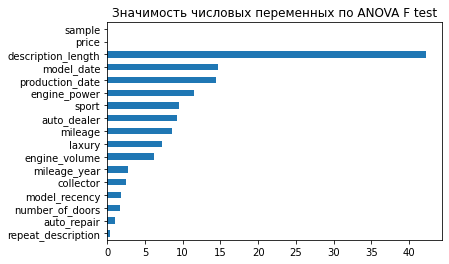

In [29]:
df_train = df.query('sample == 1')
num_cols = list(df_train.select_dtypes(include='number').columns)

imp_num = pd.Series(f_classif(df_train[num_cols], df_train['price'])[
                    0], index=num_cols)
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh', title='Значимость числовых переменных по ANOVA F test')

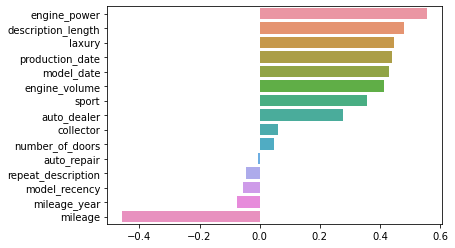

In [30]:
# Посмотрим наибольшие корреляционные связи с  переменной price
all_cols = set(df.columns) - set(['price', 'sample'])
correlations = df_train[all_cols]\
    .corrwith(df_train['price']).sort_values(ascending=False)
plot = sns.barplot(y=correlations.index, x=correlations)

## Итоги:
### В результате EDA:

* Привели признаки для теста и трейна к единой системе кодировок
* Перевели отдельные признаки к числовому формату
* Заполнили пустые значения для 4 признаков
* Удалили 2 признака с большим числом пропусков
* Выбросы не удалялись

### После Feature Engineering добавлены:

* Добавили из описания 5 бинарных признака
* Добавили 4 числовых признака из описания, пробега, года выпуска

### Датасет содержит:

* 12 числовых признаков
* 8 категориальных признаков
* 7 бинарных признаков

# OneHotLabels

In [31]:
# Сначала приведем кодировки на английский
fuel_type_dict = {'бензин': 'petrol',
                  'дизель': 'diesel',
                  'гибрид': 'hybrid',
                  'электро': 'electro',
                  'газ': 'gas'
                  }
type_of_drive_dict = {'полный': 'four_wheel',
                      'передний': 'front_wheel',
                      'задний': 'rear'
                      }
df['fuel_type'] = df['fuel_type'].map(fuel_type_dict)
df['type_of_drive'] = df['type_of_drive'].map(type_of_drive_dict)

# реализуем метод OneHotLabels
onehot_cols = ['fuel_type', 'type_of_drive']
df = pd.get_dummies(df, prefix=onehot_cols, columns=onehot_cols)
df.shape

(120076, 34)

# Label Encoding

In [32]:
df_cars = df.copy()  # Cоздадим копию DataFrame

# Кодируем категориальные признаки
cat_cols = list(df.select_dtypes(exclude='number').columns)
for column in cat_cols:
    df_cars[column] = df_cars[column].astype('category').cat.codes

<AxesSubplot:>

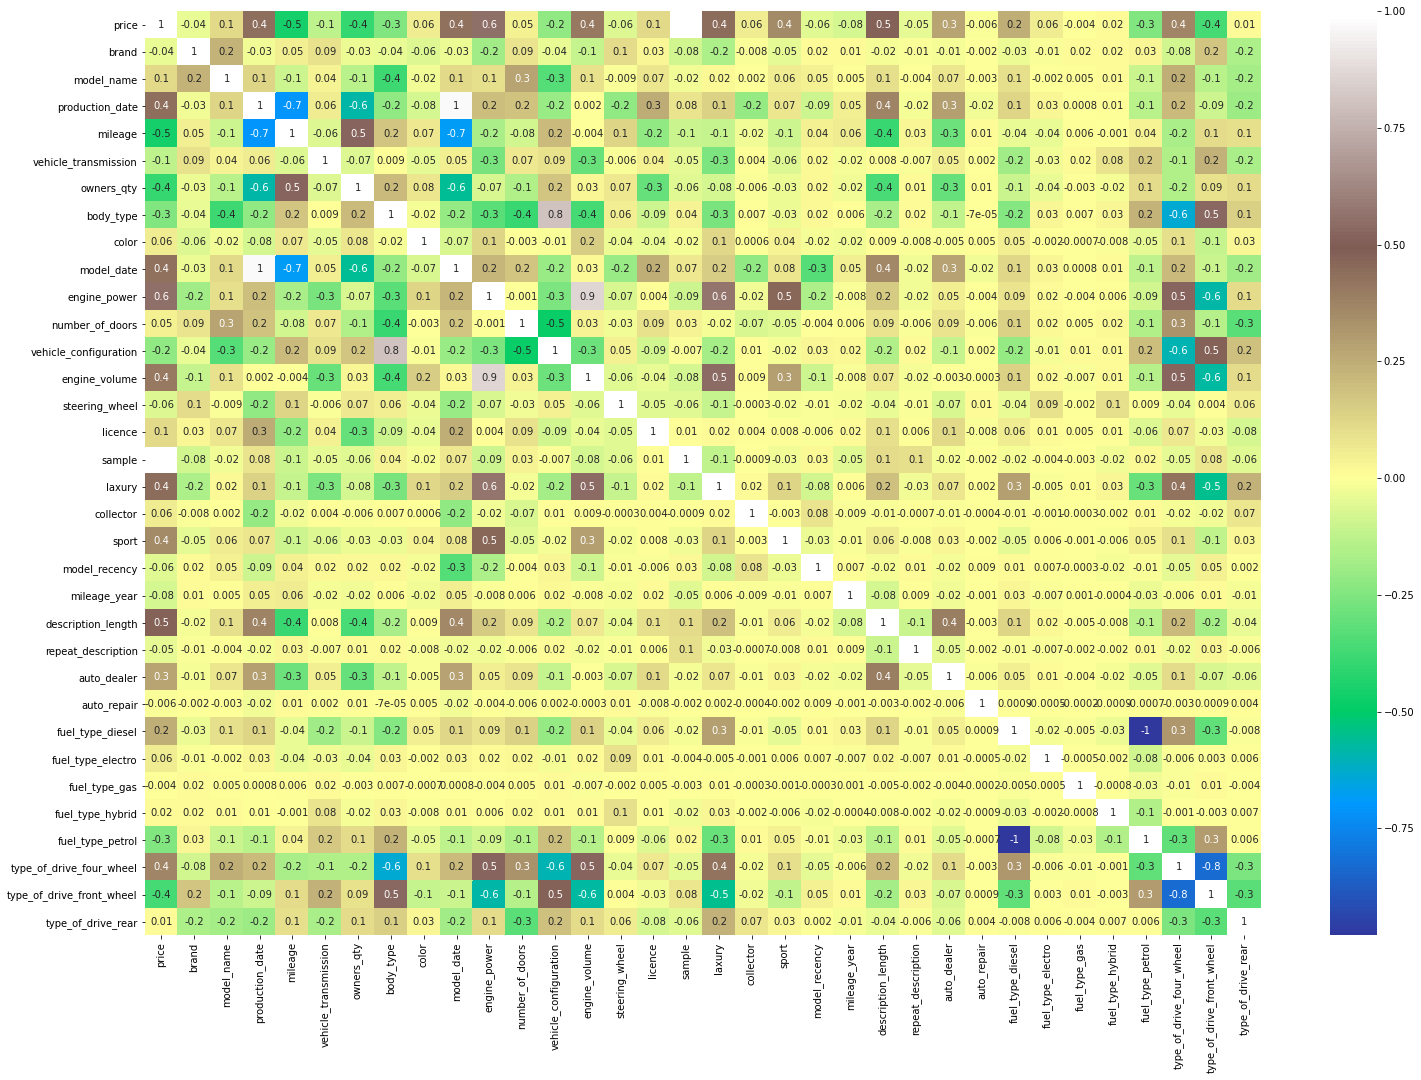

In [33]:
# посмотрим корреляционные связи между признаками
fig, ax = plt.subplots(figsize=(25, 17))
sns.heatmap(df_cars.corr(), cmap='terrain',
            annot=True, fmt='.1g', center=0, ax=ax)

## Удалим поля:

* model_date
* engine_volume
* vehicle_configuration

In [34]:
df_cars = df_cars.drop(['model_date', 'engine_volume',
                        'vehicle_configuration'], axis=1)
#Выгрузим датасет для работы на локальной машине 
# df_cars.to_csv("/kaggle/working/df_cars.csv")

In [35]:
df_cars.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 120076 entries, 0 to 120076
Data columns (total 31 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   price                      85390 non-null   float64
 1   brand                      120076 non-null  int8   
 2   model_name                 120076 non-null  int16  
 3   production_date            120076 non-null  int64  
 4   mileage                    120076 non-null  int64  
 5   vehicle_transmission       120076 non-null  int8   
 6   owners_qty                 120076 non-null  int8   
 7   body_type                  120076 non-null  int16  
 8   color                      120076 non-null  int8   
 9   engine_power               120076 non-null  float64
 10  number_of_doors            120076 non-null  float64
 11  steering_wheel             120076 non-null  int8   
 12  licence                    120076 non-null  int8   
 13  sample                     12

In [36]:
# Разделяем обратно train и test
train = df_cars.query('sample == 1').drop(['sample'], axis=1)
test = df_cars.query('sample == 0').drop(['sample', 'price'], axis=1)

# Train Split

In [37]:
RANDOM_SEED = 42
y = train['price'].values
X = train.drop(['price'], axis=1) 

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=True, random_state=RANDOM_SEED)

### Model 1: Создадим "наивную" модель

In [38]:
tmp_train = X_train.copy()
tmp_train['price'] = y_train

In [39]:
# Находим median по экземплярам engine_power в трейне и размечаем тест
predict = X_test['engine_power'].map(
    tmp_train.groupby('engine_power')['price'].median())
# не все уникальные значения engine_power были в test и train, заполним пропуски медианой
predict.fillna(predict.median(), inplace=True)
# оцениваем точность
print(f"Точность наивной модели по метрике MAPE: {(mape(y_test, predict.values))*100:0.2f}%")
# Точность наивной модели по метрике MAPE: 61.08%

Точность наивной модели по метрике MAPE: 61.08%


### Model 2: CatBoost

In [40]:
#Подбор гиперпараметров производился на локальной машине
# parameters_grid ={'depth':[4,6,8,10],
#                   'iterations':[100,300,600,1000,10000,20000],
#                   'learning_rate':[0.01,0.05,0.1,0.15,0.2]
#                  }
# "cb = CatBoostRegressor()
# grid_search_result = cb.grid_search(parameters_grid, 
#                                        X=X_train, 
#                                        y=y_train, 
#                                        plot=True)"


# В CatBoost удалось подобрать оптимальные параметры для depth = 8, learning_rate=0.15 при кол-ве итераций 20000. 
DEPTH = 8
ITERATIONS = 20000
LR = 0.15
cb = CatBoostRegressor(iterations=ITERATIONS,
                       learning_rate=LR,
                       depth=DEPTH,
                       random_seed=RANDOM_SEED,
                       eval_metric='MAPE',
                       custom_metric=['R2', 'MAE']
                       )
cb.fit(X_train, y_train,
       eval_set=(X_test, y_test),
       verbose_eval=0,
       use_best_model=True,
       )

cb.save_model('catboost_single_model_baseline.model')

# оцениваем точность
predict = cb.predict(X_test)
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict))*100:0.2f}%")
# Точность модели по метрике MAPE: 13.85%

Точность модели по метрике MAPE: 13.85%


### Model 3: RandomForest

In [41]:
rf = RandomForestRegressor(n_estimators=1000,
                           n_jobs=-1,
                           max_depth=15,
                           max_features='log2',
                           random_state=RANDOM_SEED,
                           oob_score=True)

#learn_print_MAPE(rf)

# Точность модели по метрике MAPE: 21.69%

### Model 4: LinerRegression

In [42]:
lr = LinearRegression()
learn_print_MAPE(lr)
#Точность модели по метрике MAPE: 106.71%

Точность модели по метрике MAPE: 106.71%


### Model 5: GradientBoosting

In [43]:
#Подбор гиперпараметров производился на локальной машине
# param_grid = {'learning_rate':[0.005, 0.01, 0.03], 
#               'n_estimators':[1250, 1500, 1750],
#              'max_depth':[5,10]}
# searcher = GridSearchCV(estimator=gb, param_grid=param_grid, scoring='neg_mean_squared_error', n_jobs=-1, cv=5)
# searcher.fit(X_train,y_train)
# best_ = searcher.best_params_
# print(best_)

gb = GradientBoostingRegressor(min_samples_split=2,
                               learning_rate=0.03,
                               max_depth=10,
                               n_estimators=1000)
# learn_print_MAPE(gb)

# Tочность модели по метрике MAPE: 13.70

### Model 6: LGBMRegressor

In [44]:
lgbmr = LGBMRegressor(objective='regression', max_depth=12, num_leaves=1000,
                      learning_rate=0.02, n_estimators=22000, metric='mape',
                      feature_fraction=0.6,
                      )
# learn_print_MAPE(lgbmr)

# Точность модели по метрике MAPE: 16.91%

### Model 7: Stacking

In [45]:
# По причине долгих вычислений на kaggle, пришлось ограничить число деревьев в каждом методе до 100.
estimators = [
              ('lgbmr', LGBMRegressor(objective='regression', max_depth=12, num_leaves=1000,
                                      learning_rate=0.02, n_estimators=100, metric='mape',
                                      feature_fraction=0.6,)),
              ('gbr', GradientBoostingRegressor(min_samples_split=2,
                                                learning_rate=0.03,
                                                max_depth=10,
                                                n_estimators=100))]

st_ensemble = StackingRegressor(estimators=estimators,
                                final_estimator=LinearRegression())

# оцениваем точность
st_ensemble.fit(X_train, np.log(y_train))
predict_e = np.exp(st_ensemble.predict(X_test))
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_e))*100:0.2f}%")
# Точность модели по метрике MAPE: 13.13%

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
Точность модели по метрике MAPE: 13.13%


### Итоги. Протестировано 6 типов алгоритмов с регрессорами и 1 'наивный' для наглядности
### Лучший результат точности показал стекинг на базе LGBMRegressor, GradientBoostingRegressor c meta-LinearRegression().
### В итоге, мы создали модель, которая показывает MAPE 13%, что неплохо, но можно еще улучшать модель.

### Основные признаки, которые влияют на цену автомобиля:

* мощность двигателя
* год выпуска
* пробег

# Submission

In [46]:
predict_submission = np.round(np.exp(st_ensemble.predict(test)),-3).astype('int')
predict_submission 

array([ 606000,  901000,  843000, ...,  233000, 1292000,  996000])

In [47]:
sample_submission['price'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(3)

,sell_id,price
0,1100575026,606000
1,1100549428,901000
2,1100658222,843000
